# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, log_loss, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Activation,Dropout


import warnings
warnings.filterwarnings('ignore')

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod, DeepFool, ProjectedGradientDescent
from art.attacks.evasion import FeatureAdversariesTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')
tf.compat.v1.disable_eager_execution()

In [2]:
lfw_dataset=fetch_lfw_people(min_faces_per_person=100)

print(lfw_dataset.images.shape)
print(lfw_dataset.data.shape)
print(lfw_dataset.target_names.shape)
print(lfw_dataset.target.shape)

lfw_dataset.target

Name = lfw_dataset.target_names

print(Name)
print(len(Name))

N=[]
for i in range(len(Name)):
    N+=[i]

mapping=dict(zip(Name,N))
reverse_mapping=dict(zip(N,Name))

def mapper(value):
    return reverse_mapping[value]

X0=lfw_dataset.images
y=lfw_dataset.target

print(X0.shape)
X=X0.reshape(-1,62,47,1)
print(X.shape)

dataset=[]
testset=[]
t=0
for Xi,yi in zip(X,y):
    img=Xi/255.0
    if t<=200:
        dataset.append([img,yi])
    else:
        testset.append([img,yi])
    t+=1

data,labels0=zip(*dataset)
test,tlabels0=zip(*testset)

labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)

tlabels1=to_categorical(tlabels0)
test=np.array(test)
tlabels=np.array(tlabels1)

# trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=44)
trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=1)

x_train = trainx.astype(np.float32)
x_test = testx.astype(np.float32)
y_train = trainy.astype(np.float32)
y_test = testy.astype(np.float32)

print(trainx.shape)
print(testx.shape)
print(trainy.shape)

(1140, 62, 47)
(1140, 2914)
(5,)
(1140,)
['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
5
(1140, 62, 47)
(1140, 62, 47, 1)
(160, 62, 47, 1)
(41, 62, 47, 1)
(160, 5)


In [3]:
def plot_gallery(images, titles, h=62, w=47, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    # plt.figure.patch.set_facecolor('white')
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(Name[np.argmax(titles[i])], size=12)
        plt.xticks(())
        plt.yticks(())

def plot_image(image, title):
    """Helper function to plot a gallery of portraits"""
    plt.matshow(image, cmap=plt.cm.gray)
    plt.title(Name[np.argmax(title)], size=12)
    plt.xticks(())
    plt.yticks(())

In [4]:
from art.attacks.evasion import FeatureAdversariesTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_mnist

model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(62,47,1), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=5, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Step 2a: Define the loss function and optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# model = keras.models.load_model("VGG_model_87.pth")
# datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
#                     width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")
#
# # model.fit(trainx,trainy, validation_data=(testx,testy),epochs=100, batch_size=32)
# his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=1000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 45, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 22, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 20, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 10, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4480)              0         
                                                                 
 dense (Dense)               (None, 512)               2

In [5]:
model.fit(x_train, y_train, validation_data=(testx,testy), epochs=300, batch_size=64)

Train on 160 samples, validate on 41 samples
Metal device set to: Apple M1


2023-05-28 17:06:53.386568: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-28 17:06:53.387043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-28 17:06:53.406277: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-28 17:06:53.406878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-28 17:06:53.443484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/300


2023-05-28 17:06:53.649540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-28 17:06:53.656812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 1s 4ms/sample - loss: 1.5247 - accuracy: 0.2938 - val_loss: 1.5093 - val_accuracy: 0.4390
Epoch 2/300
128/160 [=======================>......] - ETA: 0s - loss: 1.4794 - accuracy: 0.4844

2023-05-28 17:06:54.227003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 0s 925us/sample - loss: 1.4816 - accuracy: 0.4750 - val_loss: 1.4862 - val_accuracy: 0.4390
Epoch 3/300
160/160 [==============================] - 0s 532us/sample - loss: 1.3946 - accuracy: 0.4750 - val_loss: 1.4644 - val_accuracy: 0.4390
Epoch 4/300
160/160 [==============================] - 0s 687us/sample - loss: 1.3967 - accuracy: 0.4750 - val_loss: 1.4374 - val_accuracy: 0.4390
Epoch 5/300
160/160 [==============================] - 0s 910us/sample - loss: 1.3527 - accuracy: 0.4750 - val_loss: 1.5032 - val_accuracy: 0.4390
Epoch 6/300
160/160 [==============================] - 0s 831us/sample - loss: 1.3791 - accuracy: 0.4750 - val_loss: 1.4613 - val_accuracy: 0.4390
Epoch 7/300
160/160 [==============================] - 0s 787us/sample - loss: 1.3364 - accuracy: 0.4750 - val_loss: 1.4222 - val_accuracy: 0.4390
Epoch 8/300
160/160 [==============================] - 0s 756us/sample - loss: 1.3282 - accuracy: 0.4750 - val_loss: 1.4081 - val_

In [130]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 85.37%


In [129]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

In [8]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.attacks.poisoning.poisoning_attack_svm import PoisoningAttackSVM
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from art.defences.detector.poison import ProvenanceDefense, RONIDefense
from art.utils import load_mnist
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(301)

import warnings
warnings.filterwarnings('ignore')
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD


from art.estimators.classification.deep_partition_ensemble import DeepPartitionEnsemble

In [128]:
def attack(model, attack, x, y):
    x_adv = attack.generate(x)
    loss, accuracy = model.evaluate(x_adv, y)
    print('Accuracy on adversarial test examples: {}%'.format(accuracy * 100))
    return x_adv

In [10]:
x_adv = attack(model, FastGradientMethod(estimator=classifier, eps=1/255), x_test, y_test)

2023-05-28 17:07:33.092948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-28 17:07:33.260530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on adversarial test examples: 70.73171138763428%


In [12]:
accuracy_fgsm = []
eps = np.linspace(1e-3, 20/255, 20)
for _eps in eps:
    x_adv = attack(model, FastGradientMethod(estimator=classifier, eps=_eps), x_train, y_train)
    loss, accuracy = model.evaluate(x_adv, y_train)
    accuracy_fgsm.append(accuracy)

Accuracy on adversarial test examples: 100.0%
Accuracy on adversarial test examples: 100.0%
Accuracy on adversarial test examples: 98.7500011920929%
Accuracy on adversarial test examples: 75.62500238418579%
Accuracy on adversarial test examples: 45.625001192092896%
Accuracy on adversarial test examples: 25.0%
Accuracy on adversarial test examples: 18.75%
Accuracy on adversarial test examples: 15.000000596046448%
Accuracy on adversarial test examples: 13.750000298023224%
Accuracy on adversarial test examples: 10.000000149011612%
Accuracy on adversarial test examples: 8.749999850988388%
Accuracy on adversarial test examples: 6.25%
Accuracy on adversarial test examples: 5.625000223517418%
Accuracy on adversarial test examples: 5.625000223517418%
Accuracy on adversarial test examples: 4.374999925494194%
Accuracy on adversarial test examples: 3.750000149011612%
Accuracy on adversarial test examples: 3.125%
Accuracy on adversarial test examples: 3.125%
Accuracy on adversarial test examples: 

In [13]:
def plot(x, y, label, xlabel="eps", ylabel="accuracy"):
    fig, ax = plt.subplots()
    ax.plot(x, y, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.patch.set_facecolor('white')
    plt.show()

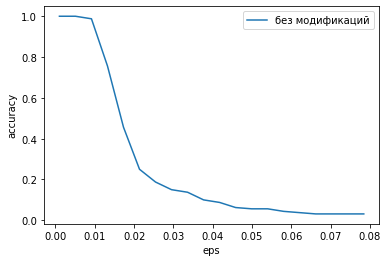

In [14]:
plot(eps, accuracy_fgsm, label="без модификаций")

In [108]:
attack_cw = CarliniLInfMethod(classifier=classifier,
                              max_iter=100,
                              learning_rate=0.01,
                              initial_const=1e0,
                              largest_const=2e0)
# modify train data with fgsm attack and retrain the model
x_adv = []
y_adv_true = []
k = 3
x_train_adv = attack(model, attack_cw, x_train[::k, :], y_train[::k, :])
y_adv_true.append([np.array([0,0,0,0,0,1]) for _ in y_train[::k, :]])
x_adv.append(x_train_adv)
k = 6
x_train_adv = attack(model, FastGradientMethod(estimator=classifier, eps=0.04), x_train[::k, :], y_train[::k, :])
y_adv_true.append([np.array([0,0,0,0,0,1]) for _ in y_train[::k, :]])
# x_adv.append(x_train_adv)
# x_train_adv = attack(model, FastGradientMethod(estimator=classifier, eps=0.04), x_train[::4, :], y_train[::4, :])
# y_adv_true.append(y_train[::4, :])
# x_adv.append(x_train_adv)

C&W L_inf:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.8518518656492233%
Accuracy on adversarial test examples: 11.11111119389534%


In [51]:
len(x_adv[0]), len(y_adv_true[0])

(160, 160)

In [109]:
# len([6 for _ in y_train[::k, :]]), y_train[::k, :].shape, np.zeros(y_train[::k, :].shape[1])
new_column = np.zeros((160, 1))  # Создание нового столбца с нулевыми значениями

# Расширение y_train
y_train_extended = np.hstack((y_train, new_column))  # Объединение y_train и нового столбца
y_train_extended.shape

(160, 6)

In [110]:
x_add_adv_data = np.array(x_train)
y_add_adv_data = np.array(y_train_extended)
for i in range(len(x_adv)):
    x_add_adv_data = np.append(x_add_adv_data, x_adv[i]).reshape(-1, 62, 47, 1)
    y_add_adv_data = np.append(y_add_adv_data, y_adv_true[i]).reshape(-1, 6)

In [111]:
x_add_adv_data.shape,y_add_adv_data.shape

((214, 62, 47, 1), (214, 6))

In [112]:
trainx_adv,testx_adv,trainy_adv,testy_adv=train_test_split(x_add_adv_data,y_add_adv_data,test_size=0.2,random_state=1)
trainx_mod,testx_mod,trainy_mod,testy_mod=train_test_split(x_train, y_train_extended,test_size=0.2,random_state=1)

In [113]:
model1 = Sequential()
model1.add(Conv2D(32,(3,3), input_shape=(62,47,1), activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(32,(3,3), activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Flatten())
model1.add(Dense(units=512, activation='relu'))
model1.add(Dense(units=128, activation='relu'))
model1.add(Dense(units=6, activation='softmax'))
model1.summary()
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 60, 45, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 20, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 10, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4480)              0         
                                                                 
 dense_9 (Dense)             (None, 512)              

In [124]:
model1.fit(trainx_mod,trainy_mod, validation_data=(testx_mod,testy_mod),epochs=300, batch_size=32)

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 0s 1ms/sample - loss: 8.2901e-06 - accuracy: 1.0000 - val_loss: 2.1324 - val_accuracy: 0.5938
Epoch 2/100
128/128 [==============================] - 0s 752us/sample - loss: 8.1293e-06 - accuracy: 1.0000 - val_loss: 2.1337 - val_accuracy: 0.5938
Epoch 3/100
128/128 [==============================] - 0s 885us/sample - loss: 7.9518e-06 - accuracy: 1.0000 - val_loss: 2.1257 - val_accuracy: 0.5938
Epoch 4/100
128/128 [==============================] - 0s 1ms/sample - loss: 7.8214e-06 - accuracy: 1.0000 - val_loss: 2.1311 - val_accuracy: 0.5938
Epoch 5/100
128/128 [==============================] - 0s 1ms/sample - loss: 7.5858e-06 - accuracy: 1.0000 - val_loss: 2.1316 - val_accuracy: 0.5938
Epoch 6/100
128/128 [==============================] - 0s 875us/sample - loss: 7.4883e-06 - accuracy: 1.0000 - val_loss: 2.1296 - val_accuracy: 0.5938
Epoch 7/100
128/128 [==============================] - 

In [116]:
eps = np.linspace(1e-4, 20/255, 20)
accuracy_fgsm = []
for _eps in eps:
    x_adv = attack(model1, FastGradientMethod(estimator=classifier, eps=_eps), trainx_mod, trainy_mod)
    y_pred = model1.predict(x_adv)
    accuracy_fgsm.append(sum([np.argmax(y_pred[i]) == np.argmax(trainy_mod[i]) for i in range(y_pred.shape[0])]) / y_pred.shape[0])

Accuracy on adversarial test examples: 100.0%


2023-05-29 19:26:59.276553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on adversarial test examples: 100.0%
Accuracy on adversarial test examples: 100.0%
Accuracy on adversarial test examples: 100.0%
Accuracy on adversarial test examples: 98.4375%
Accuracy on adversarial test examples: 91.40625%
Accuracy on adversarial test examples: 75.78125%
Accuracy on adversarial test examples: 62.5%
Accuracy on adversarial test examples: 47.65625%
Accuracy on adversarial test examples: 39.84375%
Accuracy on adversarial test examples: 32.03125%
Accuracy on adversarial test examples: 23.4375%
Accuracy on adversarial test examples: 17.1875%
Accuracy on adversarial test examples: 14.84375%
Accuracy on adversarial test examples: 13.28125%
Accuracy on adversarial test examples: 10.9375%
Accuracy on adversarial test examples: 10.9375%
Accuracy on adversarial test examples: 9.375%
Accuracy on adversarial test examples: 9.375%
Accuracy on adversarial test examples: 7.03125%


In [122]:
accuracy_fgsm

[1.0,
 1.0,
 1.0,
 1.0,
 0.984375,
 0.9140625,
 0.7578125,
 0.625,
 0.4765625,
 0.3984375,
 0.3203125,
 0.234375,
 0.171875,
 0.1484375,
 0.1328125,
 0.109375,
 0.109375,
 0.09375,
 0.09375,
 0.0703125]

In [125]:
model1.fit(trainx_adv,trainy_adv, validation_data=(testx_adv,testy_adv),epochs=30, batch_size=32)

Train on 171 samples, validate on 43 samples
Epoch 1/30
171/171 [==============================] - 0s 2ms/sample - loss: 4.1741 - accuracy: 0.4912 - val_loss: 1.5497 - val_accuracy: 0.4186
Epoch 2/30
171/171 [==============================] - 0s 1ms/sample - loss: 1.5231 - accuracy: 0.3977 - val_loss: 1.5579 - val_accuracy: 0.4186
Epoch 3/30
171/171 [==============================] - 0s 1ms/sample - loss: 1.4733 - accuracy: 0.3918 - val_loss: 1.4933 - val_accuracy: 0.3953
Epoch 4/30
171/171 [==============================] - 0s 1ms/sample - loss: 1.2997 - accuracy: 0.5263 - val_loss: 1.4535 - val_accuracy: 0.3953
Epoch 5/30
171/171 [==============================] - 0s 1ms/sample - loss: 1.1533 - accuracy: 0.5146 - val_loss: 1.3381 - val_accuracy: 0.4884
Epoch 6/30
171/171 [==============================] - 0s 1ms/sample - loss: 1.0424 - accuracy: 0.5088 - val_loss: 1.4486 - val_accuracy: 0.4186
Epoch 7/30
171/171 [==============================] - 0s 1ms/sample - loss: 0.8638 - accura

In [136]:
# x_add_adv_data = np.append(x_train, x_train_adv).reshape(-1, 62, 47, 1)
# y_add_adv_data = np.append(y_train, y_train[::3, :]).reshape(-1, 5)
x_add_adv_data.shape, y_add_adv_data.shape

((374, 62, 47, 1), (374, 5))

In [59]:
model1.fit(trainx_adv,trainy_adv, validation_data=(testx_adv,testy_adv),epochs=300, batch_size=32)

Train on 256 samples, validate on 64 samples
Epoch 1/300
256/256 [==============================] - 0s 910us/sample - loss: 0.4298 - accuracy: 0.8359 - val_loss: 1.1833 - val_accuracy: 0.5625
Epoch 2/300
256/256 [==============================] - 0s 1ms/sample - loss: 0.4211 - accuracy: 0.8359 - val_loss: 1.2837 - val_accuracy: 0.5938
Epoch 3/300
256/256 [==============================] - 0s 976us/sample - loss: 0.3711 - accuracy: 0.8633 - val_loss: 1.2442 - val_accuracy: 0.5625
Epoch 4/300
256/256 [==============================] - 0s 784us/sample - loss: 0.2902 - accuracy: 0.9297 - val_loss: 1.2604 - val_accuracy: 0.6719
Epoch 5/300
256/256 [==============================] - 0s 984us/sample - loss: 0.2408 - accuracy: 0.9297 - val_loss: 1.2236 - val_accuracy: 0.5469
Epoch 6/300
256/256 [==============================] - 0s 919us/sample - loss: 0.2432 - accuracy: 0.9375 - val_loss: 1.2647 - val_accuracy: 0.6719
Epoch 7/300
256/256 [==============================] - 0s 849us/sample - lo

In [118]:
loss_test, accuracy_test = model1.evaluate(testx_adv, testy_adv)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 72.09%


In [119]:
model.fit(x_add_adv_data,y_add_adv_data, validation_data=(testx,testy),epochs=10, batch_size=32)

ValueError: A target array with shape (214, 6) was passed for an output of shape (None, 5) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.

In [123]:
model.fit(x_train, y_train, validation_data=(testx,testy), epochs=300, batch_size=64)

Train on 160 samples, validate on 41 samples
Epoch 1/100
160/160 [==============================] - 0s 2ms/sample - loss: 4.7982e-05 - accuracy: 1.0000 - val_loss: 0.9131 - val_accuracy: 0.8537
Epoch 2/100
160/160 [==============================] - 0s 580us/sample - loss: 4.7541e-05 - accuracy: 1.0000 - val_loss: 0.9142 - val_accuracy: 0.8537
Epoch 3/100
160/160 [==============================] - 0s 631us/sample - loss: 4.7195e-05 - accuracy: 1.0000 - val_loss: 0.9153 - val_accuracy: 0.8537
Epoch 4/100
160/160 [==============================] - 0s 970us/sample - loss: 4.6847e-05 - accuracy: 1.0000 - val_loss: 0.9161 - val_accuracy: 0.8537
Epoch 5/100
160/160 [==============================] - 0s 858us/sample - loss: 4.6504e-05 - accuracy: 1.0000 - val_loss: 0.9168 - val_accuracy: 0.8537
Epoch 6/100
160/160 [==============================] - 0s 1ms/sample - loss: 4.6133e-05 - accuracy: 1.0000 - val_loss: 0.9175 - val_accuracy: 0.8537
Epoch 7/100
160/160 [==============================] 

In [126]:
accuracy_fgsm_after_modification = []
eps = np.linspace(1e-4, 20/255, 20)
accuracy_cw_prep = []
for _eps in eps:
    x_adv = attack(model1, FastGradientMethod(estimator=classifier, eps=_eps), trainx_mod, trainy_mod)
    y_pred = model1.predict(x_adv)
    accuracy_cw_prep.append(sum([np.argmax(y_pred[i]) == np.argmax(trainy_mod[i]) for i in range(y_pred.shape[0])]) / y_pred.shape[0])

Accuracy on adversarial test examples: 92.1875%
Accuracy on adversarial test examples: 89.84375%
Accuracy on adversarial test examples: 85.9375%
Accuracy on adversarial test examples: 77.34375%
Accuracy on adversarial test examples: 62.5%
Accuracy on adversarial test examples: 51.5625%
Accuracy on adversarial test examples: 42.96875%
Accuracy on adversarial test examples: 31.25%
Accuracy on adversarial test examples: 20.3125%
Accuracy on adversarial test examples: 17.96875%
Accuracy on adversarial test examples: 12.5%
Accuracy on adversarial test examples: 10.9375%
Accuracy on adversarial test examples: 9.375%
Accuracy on adversarial test examples: 8.59375%
Accuracy on adversarial test examples: 7.8125%
Accuracy on adversarial test examples: 7.03125%
Accuracy on adversarial test examples: 6.25%
Accuracy on adversarial test examples: 5.46875%
Accuracy on adversarial test examples: 4.6875%
Accuracy on adversarial test examples: 3.125%


In [80]:
x_adv = attack(model1, FastGradientMethod(estimator=classifier, eps=_eps), trainx_adv, trainy_adv)
y_pred = model1.predict(x_adv)
accuracy_cw_prep = sum([np.argmax(y_pred[i]) == 5 for i in range(y_pred.shape[0])]) / y_pred.shape[0]

Accuracy on adversarial test examples: 3.125%


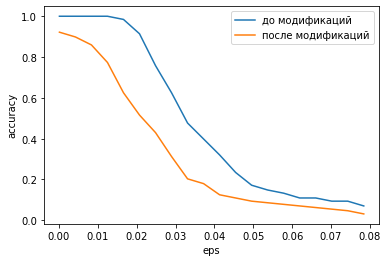

In [127]:
ssfig, ax = plt.subplots()
ax.plot(eps, accuracy_fgsm, label='до модификаций')
ax.plot(eps, accuracy_cw_prep, label='после модификаций')
ax.set_xlabel('eps')
ax.set_ylabel('accuracy')
ax.legend()
fig.patch.set_facecolor('white')
plt.show()
# plt.savefig("Обучение модели с модификацией данных вредоносными как отдельный класс.png", dpi=300, bbox_inches='tight')

In [ ]:
plot_gallery(x_adv, model.predict(x_adv))

In [ ]:
plot_gallery(x_train, y_train)